# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

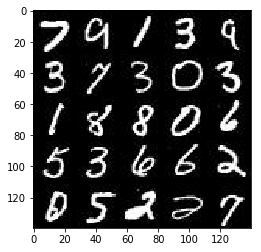

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

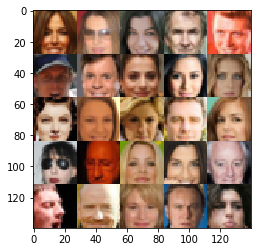

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [49]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name ='input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        #Input layer
        x1 = tf.layers.conv2d(inputs = images, filters = 64, kernel_size = 5, 
                              strides = 2, padding = 'same')
        #Leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        
        #Second layer
        x2 = tf.layers.conv2d(inputs = x1, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        #Activate LReLU
        x2 = tf.maximum(alpha * x2, x2)
        
        #Third layer
        x3 = tf.layers.conv2d(inputs = x2, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        #Activate LReLU
        x3 = tf.maximum(alpha * x3, x3)
        
        #Flattening
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        
        #Fully connected layer, depth 512
        x1 = tf.layers.dense(z, 2*2*512)
        #Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        #LReLU
        x1 = tf.maximum(alpha*x1, x1)
        
        #Second layer, depth 256
        x2 = tf.layers.conv2d_transpose(inputs = x1, filters = 256, kernel_size = 5, strides = 2, padding = 'valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        #LReLU
        x2 = tf.maximum(alpha*x2, x2)
        
        #Third layer, depth 128
        x3 = tf.layers.conv2d_transpose(inputs = x2, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        #LReLU
        x3 = tf.maximum(alpha*x3, x3)
        
        #Last layer as logits
        logits = tf.layers.conv2d_transpose(inputs = x3, filters = out_channel_dim, kernel_size = 5, strides = 2, padding = 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
        labels=tf.ones_like(d_model_real)))
 
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake,
        labels = tf.zeros_like(d_model_fake)))
 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake,
        labels = tf.ones_like(d_model_fake)))
 
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
 
    # Optimise
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
 
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
 
    # Discriminator/generator training operations
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [59]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    inputs_real, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
            
            # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

            # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z: batch_images, z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, z, data_shape[3], data_image_mode)
                    #show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)''' 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3402... Generator Loss: 6.3040
Epoch 1/2... Discriminator Loss: 0.0207... Generator Loss: 11.6687
Epoch 1/2... Discriminator Loss: 0.0104... Generator Loss: 6.3930
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 2.2004
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 0.4252... Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 4.3123... Generator Loss: 9.8229
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 2.9483
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 0.2839... Generator Loss: 2.7850


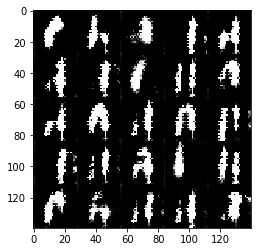

Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 3.9461
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 1.7512
Epoch 1/2... Discriminator Loss: 1.6688... Generator Loss: 6.4434
Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 2.2121
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 1.1299
Epoch 1/2... Discriminator Loss: 2.2236... Generator Loss: 5.0471
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 1.7155
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.7376... Generator Loss: 0.5725


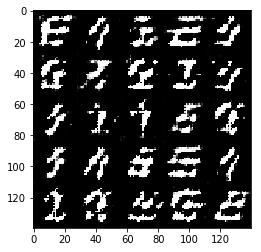

Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 3.0524
Epoch 1/2... Discriminator Loss: 0.5891... Generator Loss: 5.4648
Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 3.9845
Epoch 1/2... Discriminator Loss: 0.6578... Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.4935
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 3.3677
Epoch 1/2... Discriminator Loss: 1.8514... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 4.3962
Epoch 1/2... Discriminator Loss: 1.6464... Generator Loss: 7.1319


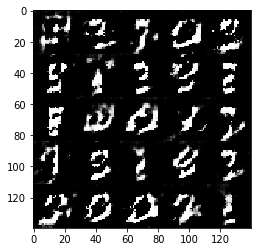

Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.1990
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.7310
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 2.2303
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.9398
Epoch 1/2... Discriminator Loss: 1.8241... Generator Loss: 0.3243
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 2.4432
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 1.1854
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 1.6590


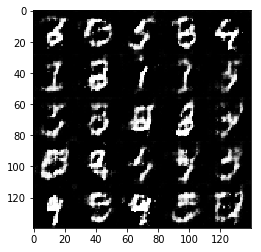

Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.9638
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.3011
Epoch 1/2... Discriminator Loss: 2.2051... Generator Loss: 0.3073
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.5967
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 0.4938... Generator Loss: 2.1944
Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 4.9325
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.7500
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 1.5424


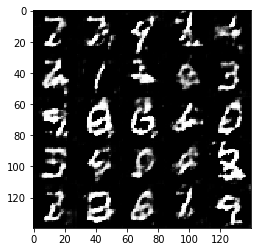

Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.2812
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 1.4302
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 0.9911
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 1.8418


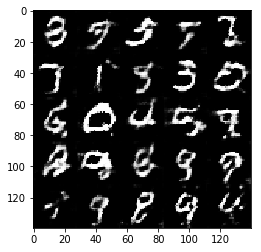

Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.4801
Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 0.3166
Epoch 1/2... Discriminator Loss: 0.7719... Generator Loss: 1.1854
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.1444
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.3212
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.3896
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 1.2840
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 2.8150
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.4308


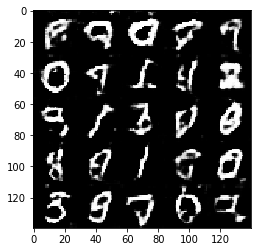

Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 0.9704
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 3.0499
Epoch 1/2... Discriminator Loss: 3.1044... Generator Loss: 4.6763
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.3978
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 1.1038


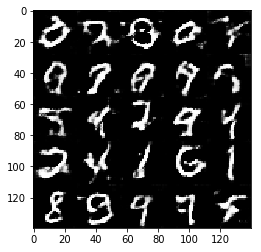

Epoch 1/2... Discriminator Loss: 1.8833... Generator Loss: 3.1276
Epoch 1/2... Discriminator Loss: 0.6491... Generator Loss: 1.6460
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.2601
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 2.0513... Generator Loss: 3.6024
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.1841


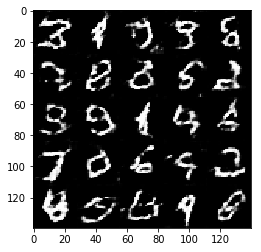

Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 2.9200
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 2.4437
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 2.6928
Epoch 2/2... Discriminator Loss: 0.6431... Generator Loss: 1.7247
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 3.6577
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 3.5608
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.2796


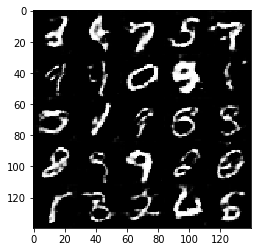

Epoch 2/2... Discriminator Loss: 0.5449... Generator Loss: 1.3000
Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.5639
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 2.6686
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.2027
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.5584
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 3.4743... Generator Loss: 6.6449
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.8680


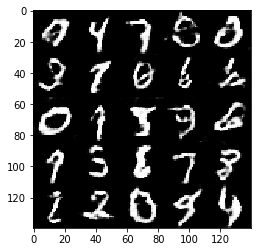

Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.7349
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 3.1282
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 2.7581
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.7534... Generator Loss: 0.3247
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.1809


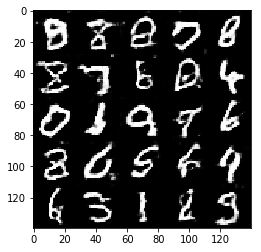

Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 3.5005
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.5507
Epoch 2/2... Discriminator Loss: 1.5990... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 1.3535
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 0.8784
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 2.1048
Epoch 2/2... Discriminator Loss: 1.4845... Generator Loss: 2.4250


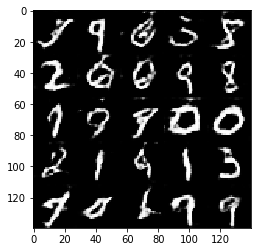

Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.7680
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.3655
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 2.4565... Generator Loss: 4.2181
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.6536
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 2.4896
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 0.9007


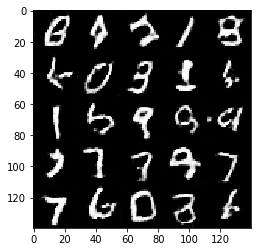

Epoch 2/2... Discriminator Loss: 2.6215... Generator Loss: 0.2187
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 1.4514... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 1.7555
Epoch 2/2... Discriminator Loss: 0.2397... Generator Loss: 2.2158
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.5019
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.2070


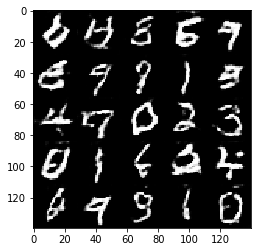

Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 3.0552
Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 2.3596
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.5635
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 2.6155
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 1.9790
Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 1.6105


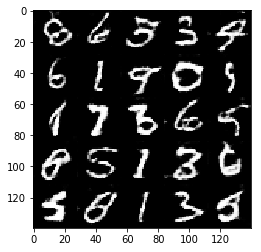

Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 1.4326
Epoch 2/2... Discriminator Loss: 3.4960... Generator Loss: 0.0709
Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 3.4082
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.8116
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.5273
Epoch 2/2... Discriminator Loss: 0.5414... Generator Loss: 2.7546
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.5739


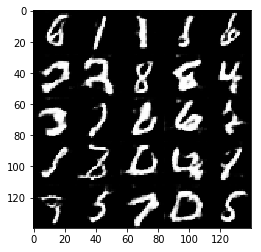

Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 2.1103
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.4493
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 1.6359... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.5158
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 2.2791
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.3336
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.2395


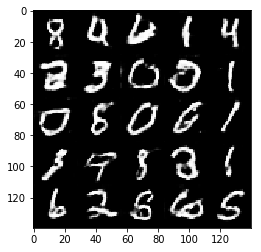

Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 2.7319
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.5056
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.1236


In [60]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [61]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 6.0992
Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 2.9047
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 3.9744
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 3.0291
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 6.2678
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.7222
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 5.7561
Epoch 1/1... Discriminator Loss: 5.0821... Generator Loss: 0.0360
Epoch 1/1... Discriminator Loss: 2.7248... Generator Loss: 0.2670


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.